$$\textbf{Abstract}$$
Quantum Signal Processing(QSP)[1][2] applies polynomial transformations through composite rotation sequences. It forms the basis of Quantum Singular Value Transformation(QSVT)[3][4], where these phase sequences are used to transform the singular values of unitary matrices. QSVT is often regarded as a unifying framework for quantum algorithms, with major algorithms like Grover’s Search Algorithm[5], and Hamiltonian Simulation[6] and sub-parts of Shor’s Factoring Algorithm[7] emerging as specific cases. The challenge of finding optimal phase factors for QSP has persisted for years, with various classical methods proposed for finding and optimizing the phase factors[8][9]. This project aims to leverage quantum machine learning tools to explore and optimize phase factors for QSP.

# Background

## Quantum Signal Processing

$\textbf{Theorem 1}$(Quantum Signal Processing(QSP)): The QSP sequence $\vec{\phi}=\{\phi_0,\phi_1,...,\phi_k\}$ produces a matrix which may be expressed as polynomial function of a:


$$
\begin{equation*}        
    e^{i \phi_0 \sigma_z} \prod_{k=1}^d  W(a)  e^{i\phi_k \sigma_z} = 
    \begin{pmatrix}
        P(a) & iQ(a)\sqrt{1-a^2} \\
        iQ^*(a)\sqrt{1-a^2} & P^*(a)
    \end{pmatrix}
    ,\hspace{2mm}
    W(a) = 
    \begin{pmatrix}
        a & i \sqrt{1-a^2} \\
        i \sqrt{1-a^2} & a
    \end{pmatrix}
\end{equation*}
$$

for a $\in$ [-1, 1], a phase sequence $\vec{\phi}$ exists for any polynomials P, Q in a such that:

1. $\text{deg}(P) \leq d$, $\text{deg}(Q) \leq d-1$
2. $P$ has parity $d \mod 2$ and $Q$ has parity $(d-1) \mod 2$
3. $|P|^2 + (1-a^2) |Q|^2 = 1$

For a polynomial satisfying these conditions, a phase sequence $\vec{\phi}$ exists that applies the transformation. However, finding the phase factors is challenging because of emerging constraints on the achievable polynomials. Current approaches involve approximating the target polynomial to fit
the conditions in Theorem 1, then using various classical numerical methods to find and optimize the phase factors. The goal of this project is to explore this problem using quantum machine learning techniques, with the use of variational quantum circuits to determine these phase factors, investigating suitable cost functions and optimizers.

The motivation for this approach is to explore the use of quantum computers to find the target phase sequence. This work is, due to time limitations and access to real quantum devices, only a proof of concept. It could be used on analog quantum computers which serves only one problem(or a limited amount). If the phase factors could be trained on the device which would be used for a given problem, it could allow us to mitigate some of the error, and therefore achieving better accuracy.

# Methodology

The methodology for this work is as follows;

1. Construct a parameterized circuit with parameters $\vec{\phi}=\{\phi_0,\phi_1,...,\phi_k\}$
2. Define a cost function
3. Define an optimizer
4. Find parameters by trial, minimizing the cost function

<figure style="text-align: center;">
    <img src="visuals\circ.png" alt="image" width="500" />
    <figcaption>Figure 1:  QSVT Parameterized Circuit</figcaption>
</figure>

## Parameterized Circuit

The parameterized circuit used in this project is as in Figure 1. $\phi_j$ and $W(x)$ defined as in Theorem 1.

$$
U_{\phi_j} = 
\begin{pmatrix}
        e^{i\phi_j} & 0 \\
        0 & e^{-i\phi_j}
\end{pmatrix}
,\hspace{2mm}
W(x) = 
\begin{pmatrix}
    x & i \sqrt{1-x^2} \\
    i \sqrt{1-x^2} & x
\end{pmatrix}
$$

$W(x)$ is the fixed signal rotation. Therefore by increasing the number of qubits, we can control how many points we train the circuit to fit the target polynomial. Given a single qubit(thus, by training for only single point), it is unlikely to achieve a target polynomial since there are infinitely many polynomials passing through a fixed single point. However, this project involves also single point fitting as it could also be used in a problem where only a single point is of interest.

## Cost Function

The cost function used is a distance function. Given a target polynomial $f(x)$ with definite parity, and a QSVT circuit $U_{qsvt}$ defined in Theorem 1,
for an arbitrary point $x_0 \in [-1, 1]$ the distance function is defined by

$$
dist =  |f(x_0) - \bra0 U_{circuit}\ket0|
$$

We want to minimize the dist function so that, for sufficiently small $\epsilon \in \Re$

$$
dist \le \epsilon
$$

## Optimizer

The optimizer used is a simple grid search. The reasoning behind this approach was to be able to send multiple circuits to a real quantum hardware to compare the results with simulations. This comparison is not present in this final report since due to limited access and time, it was not possible to achieve compareable results.

The grid search optimizer works as follows: given an initial set of phase factors the algorithm iterates over each phase factor with a given interval and grid size. Each iteration on all phase factors, the next iteration scales down the interval.

Let first phase factor in an arbitrary random set of parameters be $\phi_0 \in \vec{\phi}$, and let the starting interval be $2\pi$ with grid size k, then our first set of trial values for $\phi_0$ is

$$
\{ (\phi_0 - \pi), (\phi_0 - \pi) + \frac{2\phi}{k} , (\phi_0 - \pi) + 2\frac{2\phi}{k}, ... , (\phi_0 + \pi) \}
$$

after calculating the cost of each trial parameters, we update the parameter that minimizes the cost. After the first iteration, where we go through all the parameters in the circuit. Repeat with half of the previous interval, such that

$$
\{ (\phi_{j_{updated}} - \frac{\pi}{2}), ((\phi_{j_{updated}} - \frac{\pi}{2}) + \frac{\phi}{k} , ... , ((\phi_{j_{updated}} + \frac{\pi}{2}) \}
$$

# Application

First we import all the packages needed and define the functions described in Methodology section.

In [1]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RXGate, RZGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
import time

In [2]:
#color palette of visuals
target_color = "#E38E49"
output_color = "#0A3981"
output_color_fade1 = "#1F509A"
output_color_face2 = "#D4EBF8"

In [3]:
#utility functions
def replace_element(list, index, new_value): #replace an element in an array given an index
    return [new_value if i == index else x for i, x in enumerate(list)]

In [4]:
def func(x):
    y = (0.5) * (5 * x**6 - 3 * x**2 - 1) #random target function
    return y

def qsvt_circuit(parameter_vector, signal):
    qc = QuantumCircuit(1,1)
    qc.h(0) #h is arbitrary so that <0|U|0> -> <+|U|+>
    qc.rz(parameter_vector[0], 0)
    for i in range(len(parameter_vector)-1):
        qc.rx(signal, 0)
        qc.rz(parameter_vector[i+1], 0)
    qc.h(0) #h is arbitrary so that <0|U|0> -> <+|U|+>
    return qc

observable = SparsePauliOp("Z")
estimator = StatevectorEstimator()
def exp_value(qc, weights): #with exactly defined "observable", "estimator"
    qc1 = qc.assign_parameters(weights)
    pub = (qc1, observable)
    job = estimator.run([pub])
    evs = job.result()[0].data.evs
    return evs

def loss(signal, qc, weights):
    real = func(np.cos(signal/2))
    evs = exp_value(qc, weights)
    dist = np.abs(real - evs)
    return dist

In [5]:
#function that optimizes selected parameter and returns the weights that minimizes loss function
def optimize_index(index, interval, interval_split_size, qc, initial_weights): #define the search points for the given index
  search_points = np.linspace(initial_weights[index] - (interval/2), initial_weights[index] + (interval/2), interval_split_size)
  optimized_weights = initial_weights
  current_loss = loss(signal, qc, optimized_weights) #initial loss for reference
  for i in search_points: #loop over search points and if less than loss update
    current_weights = replace_element(optimized_weights, index, i)
    loss_value=loss(signal, qc, current_weights)

    if loss_value < current_loss:
      current_loss = loss_value
      optimized_weights = current_weights
    #track.append(optimized_weights)
  return optimized_weights
    
##function that goes over all parameters and returns the weights that minimizes loss function
def optimize_weights(interval, interval_split_size, qc, initial_weights):
    optimized_weights = initial_weights
    for i in range(len(optimized_weights)):
        optimized_weights = optimize_index(i, interval, interval_split_size, qc, optimized_weights)
    #print(f"initial loss: {loss(signal, qc, initial_weights)}, final loss={loss(signal, qc, optimized_weights)}")
    return optimized_weights

#iteratively halves the interval and optimizes again
def iterate_optimize_weights(iteration, initial_interval, interval_split_size, qc, initial_weights, track=None):
    weights = initial_weights
    for i in range(iteration):
        interval = initial_interval/(2**i)
        weights = optimize_weights(interval, interval_split_size, qc, weights)
        if (i % 5) == 0: print(f"iteration {str(i)} done with interval: pi/{2**i}, final loss={loss(signal, qc, weights)}")
        if track != None: track.append(weights)
    return weights

## Single Point Approximation 

First Plot the target function by itself, and a random point on the polynomial which we will train

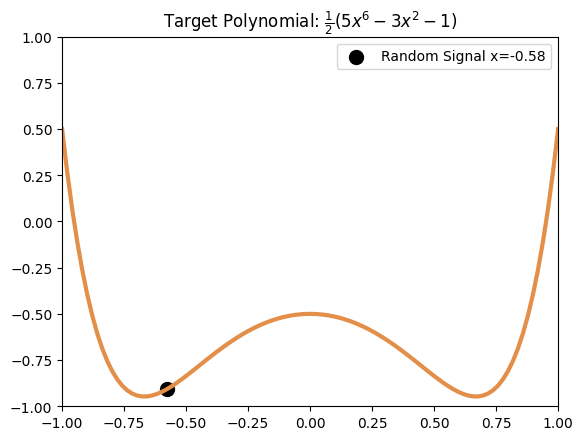

In [6]:
np.random.seed(123)
x_values = np.linspace(-1,1, 100)
signal = np.random.uniform(0, np.pi * 2)
plt.plot(x_values, func(x_values), color="#E38E49", linewidth=3)
plt.scatter(np.cos(signal/2), func(np.cos(signal/2)), s=100, color="black", label=f"Random Signal x={round(np.cos(signal/2),2)}")
plt.xlim(-1,1); plt.ylim(-1,1); plt.title(r'Target Polynomial: $\frac{1}{2}(5x^6 - 3x^2 -1)$'); plt.legend()
plt.show()

Now let's train a single qubit circuit with the random parameter

In [7]:
np.random.seed(123)
k = 4 #number of parameters in the circuit
parameter_vector = ParameterVector(r"$\theta$", k)
qc = qsvt_circuit(parameter_vector, signal)

initial_weights = np.random.uniform(low=0, high=2*np.pi, size=(1, k))[0] #initial random parameter values

grid_split = 6 #how many sections the interval will be splitted
inter = 2*np.pi #initial interval
iteration = 51

optimized_weights = iterate_optimize_weights(iteration, inter, grid_split, qc, initial_weights)

iteration 0 done with interval: pi/1, final loss=0.006126549968486827
iteration 5 done with interval: pi/32, final loss=0.0001996348337103271
iteration 10 done with interval: pi/1024, final loss=3.3359133447818934e-06
iteration 15 done with interval: pi/32768, final loss=1.5025094579623754e-07
iteration 20 done with interval: pi/1048576, final loss=9.340774820287834e-10
iteration 25 done with interval: pi/33554432, final loss=1.5638812467244634e-10
iteration 30 done with interval: pi/1073741824, final loss=1.5800694086465228e-12
iteration 35 done with interval: pi/34359738368, final loss=6.139533326177116e-14
iteration 40 done with interval: pi/1099511627776, final loss=1.9984014443252818e-15
iteration 45 done with interval: pi/35184372088832, final loss=2.220446049250313e-16
iteration 50 done with interval: pi/1125899906842624, final loss=0.0


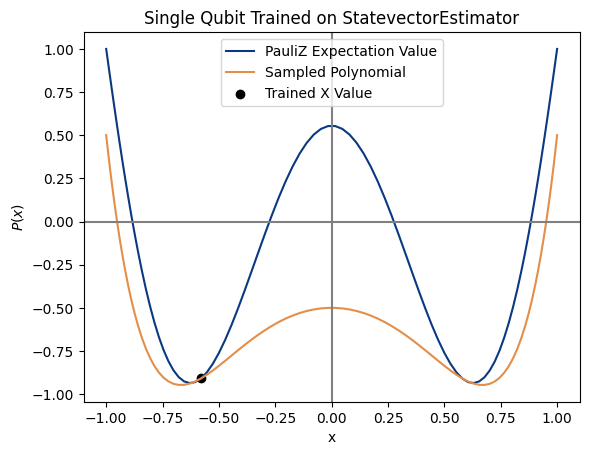

In [8]:
x_range=np.linspace(0, 2*np.pi, 100)
losses = []; exp_values = []; x_value = np.cos(x_range/2)

for i in x_range:
    qc = qsvt_circuit(parameter_vector, i)
    exp_values.append(exp_value(qc, optimized_weights))
    losses.append(loss(i, qc, optimized_weights))

plt.plot(x_value, exp_values, color='#0A3981', label="PauliZ Expectation Value")
plt.plot(x_value, func(x_value), color='#E38E49', label="Sampled Polynomial")
#plt.scatter(np.cos(signal/2), func(np.cos(signal/2)), 100, label='Trained x value')
plt.scatter(np.cos(signal/2), func(np.cos(signal/2)), color='black', label='Trained X Value')
plt.axvline(x=0,color="gray")
plt.axhline(y=0,color="gray")
plt.title("Single Qubit Trained on StatevectorEstimator")
plt.ylabel(r"$P(x)$")
plt.xlabel(r'x')
plt.legend()
plt.show()

## Multiple Qubit Approximation

Now let's do the same but slightly modify the cost function so that the distance function is the average of distance values for our training points

Redefine the necessary functions(multiple qubit qsvt, cost)

**Note:** For expectation value function we need to define our new observables as(PauliZ for eqach qubit)

In [9]:
def qsvt_circuit1(parameter_vector, signal): #for visual
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc.rz(parameter_vector[0], 0)
    for i in range(len(parameter_vector)-1):
        qc.rx(signal, 0)
        qc.rz(parameter_vector[i+1], 0)
    qc.h(0)
    return qc
def exp_value1(qc, weights): #for visual
    qc1 = qc.assign_parameters(weights)
    pub = (qc1, observable)
    job = estimator.run([pub])
    evs = job.result()[0].data.evs
    return evs
def loss1(signal, qc, weights): #for visual
    real = func(np.cos(signal/2))
    evs = exp_value1(qc, weights)
    dist = np.abs(real - evs)    
    return dist
    
def qsvt_circuit(n_qubits, parameter_vector, signal): #new qsvt with multiple qubits
    if len(signal) != n_qubits: return print("incorrect signal length for the given circuit size")
    qc = QuantumCircuit(n_qubits)
    qc.h(qc.qubits)
    qc.rz(parameter_vector[0], qc.qubits)
    for i in range(len(parameter_vector)-1):
        for j in range(len(qc.qubits)):
            qc.rx(signal[j], j)
        qc.rz(parameter_vector[i+1], qc.qubits)
    qc.h(qc.qubits)
    return qc

#redefined observables for 5 qubits(therefore 5 points on the target polynomial)
n = 5
observable = [SparsePauliOp("IIIIZ"), SparsePauliOp("IIIZI"), SparsePauliOp("IIZII"),SparsePauliOp("IZIII"),SparsePauliOp("ZIIII")]

def loss(signal, qc, initial_weights):
    real = func(np.cos(signal/2))
    evs = exp_value(qc, initial_weights)
    dist = np.abs(real - evs)
    ave_loss = np.average(dist)
    #print(dist)
    return ave_loss

Now lets plot the target polynomial again with our 5 training points

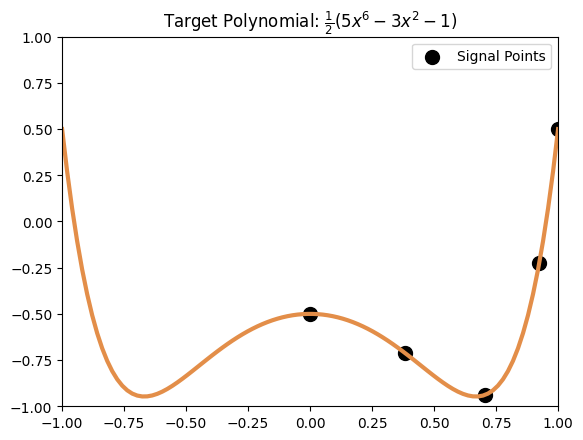

In [10]:
np.random.seed(123)
x_values = np.linspace(-1,1, 100)
signal = np.linspace(0, np.pi, n)
plt.plot(x_values, func(x_values), color="#E38E49", linewidth=3)
plt.scatter(np.cos(signal/2), func(np.cos(signal/2)), s=100, color="black", label=f"Signal Points")
plt.xlim(-1,1); plt.ylim(-1,1); plt.title(r'Target Polynomial: $\frac{1}{2}(5x^6 - 3x^2 -1)$'); plt.legend()
plt.show()

Train the circuit for our given points

In [11]:
k = 5
parameter_vector = ParameterVector(r"$\theta$", k)
signal = np.linspace(0.4, np.pi, n)
qc = qsvt_circuit(n, parameter_vector, signal)

grid_split = 4 #how many sections the range will be splitted
inter = 2*np.pi
iteration = 36

np.random.seed(1)
initial_weights = np.random.uniform(low=0, high=2*np.pi, size=(1, k))[0]

start_time = time.time()
optimized_weights = iterate_optimize_weights(iteration, inter, grid_split, qc, initial_weights)
end_time = time.time()

iteration 0 done with interval: pi/1, final loss=0.23655542256328257
iteration 5 done with interval: pi/32, final loss=0.015733799652435886
iteration 10 done with interval: pi/1024, final loss=0.007276422041358499
iteration 15 done with interval: pi/32768, final loss=0.0069459339817135035
iteration 20 done with interval: pi/1048576, final loss=0.006930492235043684
iteration 25 done with interval: pi/33554432, final loss=0.006930266756126213
iteration 30 done with interval: pi/1073741824, final loss=0.006930257290936747
iteration 35 done with interval: pi/34359738368, final loss=0.006930256839286686


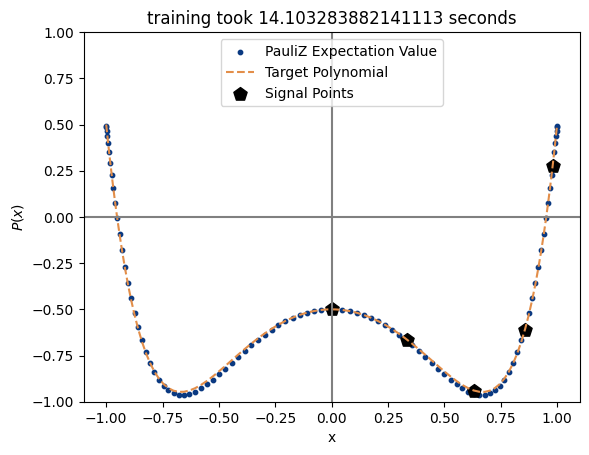

In [12]:
observable=SparsePauliOp("Z")
x_range=np.linspace(2*np.pi, 0, 100)
parameter_vector = ParameterVector(r"$\theta$", k)
exp_values = []
x_value = np.cos(x_range/2)

for i in x_range:
    qc2 = qsvt_circuit1(parameter_vector, i)
    exp_values.append(exp_value1(qc2, optimized_weights))
    losses.append(loss1(i, qc2, optimized_weights))

plt.scatter(x_value, exp_values, color=output_color, s=10, label="PauliZ Expectation Value")
plt.plot(x_value, func(x_value),'--', color=target_color, label="Target Polynomial")
plt.scatter(np.cos(signal/2), func(np.cos(signal/2)), marker='p', color="black", s=100, label='Signal Points')
#plt.scatter(np.cos(signals/2), exp_circuit, label='circuit_exp')
plt.axvline(x=0,color="gray"); plt.axhline(y=0,color="gray")
plt.title(f"training took {end_time - start_time} seconds")
plt.xlabel(r"x")
plt.ylabel(r"$P(x)$")
plt.ylim(-1,1)
plt.legend(loc='upper center')
plt.show()

# Results

Here are some iterations on different functions,

## Target function $cos(x)$ 
Since we can calculate the distance directly, we don't need to approximate the even polynomial for it. Below is directly trained using cosine function

<figure style="text-align: center;">
    <img src="visuals\gifs\cosSim.gif" alt="gif" width="600" />
    <figcaption>Figure 2:  Evolution of polynomial transformation each iteration</figcaption>
</figure>

**Note:** Figures 2, 4, 6, 7 are animated. Link to github can be found at the end if this is a pdf version.}

<figure style="text-align: center;">
    <img src="visuals\cosSimPNG.png" alt="image" width="600" />
    <figcaption>Figure 3:  Trained cos(x) transformation</figcaption>
</figure>

## Target function $cos(2x)$
Same as above below is trained on directly the function $cos(2x)$

<figure style="text-align: center;">
    <img src="visuals\gifs\cos2Sim.gif" alt="gif" width="600" />
    <figcaption>Figure 4: Animated polynomial transformation</figcaption>
</figure>

<figure style="text-align: center;">
    <img src="visuals\cos2SimPNG.png" alt="image" width="600" />
    <figcaption>Figure 5:  Trained cos(2x) transformation</figcaption>
</figure>

## Target function $\frac{1}{2}(5x^4 - 3x^2 -1)$

<figure style="text-align: center;">
    <img src="visuals\gifs\SimResult.gif" alt="gif" width="600" />
    <figcaption>Figure 6: Animated polynomial transformation</figcaption>
</figure>

## Single attempt at the quantum hardware "ibm_kyiv"(Target: $\frac{1}{2}(5x^6 - 3x^2 -1)$)

The following result is not compareable since probably the optimizer has been stuck on a local minimum. Since limited access is allowed on IBM's services below is the only result achieved in real quantum hardware.

<figure style="text-align: center;">
    <img src="visuals\gifs\ibm_poly.gif" alt="gif" width="600" />
    <figcaption>Figure 7: Animated polynomial transformation</figcaption>
</figure>



## Conclusion

Finding phase factors using variational circuits offers a practical alternative to traditional classical methods. Variational circuits leverage the strengths of quantum computing, providing a way to optimize phase factors in a more adaptable and "potentially" efficient manner. By combining both classical and variational approaches, we can fine-tune these phase factors to better match the specific capabilities of the hardware and address the unique requirements of different problems. This hybrid method not only enhances flexibility but also opens up possibilities for improving overall performance and accuracy. As quantum hardware continues to evolve, this combined approach may play a crucial role in maximizing the benefits of both classical and quantum resources, leading to more robust and effective solutions in various applications.

### Future Work

As mentioned in the beginning, the main motivation of this project was to compare the simulation to the hardware trained results. Therefore, the next step would be to explore how this project would work on real hardware. It is also possible to explore better optimization techniques or better strategies to run circuit batchs with better efficiency. 

## References

**[1]** Guang Hao Low, Theodore J. Yoder, and Isaac L. Chuang. Methodology of resonant equiangular composite quantum gates. Physical Review X, 6(4), December 2016.

**[2]** Guang Hao Low and Isaac L. Chuang. Optimal hamiltonian simulation by quantum signal processing. Physical Review Letters, 118(1), January 2017.

**[3]** Andr´as Gily´en, Yuan Su, Guang Hao Low, and Nathan Wiebe. Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing, qsvt. ACM, June 2019.

**[4]** John M. Martyn, Zane M. Rossi, Andrew K. Tan, and Isaac L. Chuang. Grand unification of quantum algorithms. PRX Quantum, 2(4), December 2021.

**[5]** Lov K. Grover. A fast quantum mechanical algorithm for database search, 1996.

**[6]** Richard P. Feynman. Simulating physics with computers. International Journal of Theoretical Physics, 21(6):467–488, 1982.

**[7]** Peter W. Shor. Polynomial-time algorithms for prime factorization and discrete logarithms on a quantum computer. SIAM Journal on Computing, 26(5):1484–1509, October 1997.

**[8]** Yulong Dong, Xiang Meng, K. Birgitta Whaley, and Lin Lin. Efficient phase-factor evaluation in quantum signal processing. Physical Review A, 103(4), April 2021.

**[9]** Hongkang Ni and Lexing Ying. Fast phase factor finding for quantum signal processing, 2024.
